<a href="https://colab.research.google.com/github/uqer-jyh/Analysis-and-visualization-of-spatial-transcriptomics-data/blob/main/marker_genes_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [ ]:
!pip install scanpy
!pip install decoupler
!pip install leidenalg
!pip install igraph
!pip install omnipath


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Run this cell if you have not unzip your files.

In [3]:
# !tar -xvf "/content/drive/MyDrive/Mariella_scRNAseq/GSE184357_DMG_raw_counts.tar" -C "/content/drive/MyDrive/Mariella_scRNAseq/"
# !tar -xvf "/content/drive/MyDrive/Mariella_scRNAseq/GSE184357_scATAC_counts.tar" -C "/content/drive/MyDrive/Mariella_scRNAseq/"


In [4]:
ls /content/drive/MyDrive/Mariella_seq

CellMarker_DB/                human_mouse_scrna.h5ad      scATAC_counts/
GSE184357_DMG_raw_counts.tar  human_only_scrna.h5ad       scRNA_counts/
GSE184357_scATAC_counts.tar   human_sensitive_scrna.h5ad


In [5]:
cd /content/drive/MyDrive/Mariella_seq

/content/drive/MyDrive/Mariella_seq


# Import packages

In [6]:
# Load the packages
import os
import sys
import gc
import scanpy as sc
import decoupler as dc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

# Preprocessing

QC, projection and clustering

In [7]:
def basic_qc(adata):

    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=1)

    # Annotate the group of mitochondrial genes as 'mt'
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    # Filter cells following standard QC criteria.
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :]

    # Normalize the data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.layers['log_norm'] = adata.X.copy()
    return adata


In [8]:
# Load real dataset
scrna_path = '/content/drive/MyDrive/Mariella_seq/scRNA_counts'
batch_ids = os.listdir(scrna_path)
adatas = []
for batch_id in batch_ids:
    print(batch_id)
    adata = pd.read_csv(scrna_path + '/' + batch_id, index_col=0).T
    adata = sc.AnnData(adata)
    adata.obs['batch'] = batch_id.replace('cm_counts_', '').replace('.csv', '')
    adata = basic_qc(adata)
    adatas.append(adata)
    del adata
    gc.collect()
adata = sc.concat(adatas,
                  # join='outer'
                  )
adata


cm_counts_SUDIPG65.csv
cm_counts_BCH869.csv
cm_counts_MGH66.csv
cm_counts_MUV5_2.csv
cm_counts_BT1179.csv
cm_counts_MUV091.csv
cm_counts_GBM96.csv
cm_counts_MUV77.csv
cm_counts_MUV054.csv
cm_counts_BCH869_2.csv
cm_counts_BCH836_2.csv
cm_counts_DIPG50aut1.csv
cm_counts_MUV032.csv
cm_counts_BCH1126.csv
cm_counts_MUV10.csv
cm_counts_XT9824.csv
cm_counts_DIPG50bio.csv
cm_counts_SUDIPGIII.csv
cm_counts_MUV10_2.csv
cm_counts_BCH1462.csv
cm_counts_BCH836.csv
cm_counts_MUV031.csv
cm_counts_MUV017.csv
cm_counts_GBM27.csv
cm_counts_MUV35.csv
cm_counts_MUV16.csv
cm_counts_MUV87.csv
cm_counts_MUV83.csv
cm_counts_R1E1E3G3.csv
cm_counts_pSCG1.csv
cm_counts_AAA076530001.csv
cm_counts_MUV86.csv
cm_counts_XT8698.csv
cm_counts_SUDIPG52.csv
cm_counts_SUDIPG55biop.csv
cm_counts_pTG4.csv
cm_counts_SUDIPG54.csv
cm_counts_MUV5.csv
cm_counts_MUV78.csv
cm_counts_SUDIPG30.csv
cm_counts_MUV82.csv
cm_counts_SUDIPG31.csv
cm_counts_GBM60.csv
cm_counts_SUDIPG45.csv
cm_counts_pTG5.csv
cm_counts_S1D2E3H7.csv
cm_counts

AnnData object with n_obs × n_vars = 3869 × 7551
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    layers: 'log_norm'

Group cells based on the similarity of their transcription profiles. Using UMAP reduction to visualize the communities.

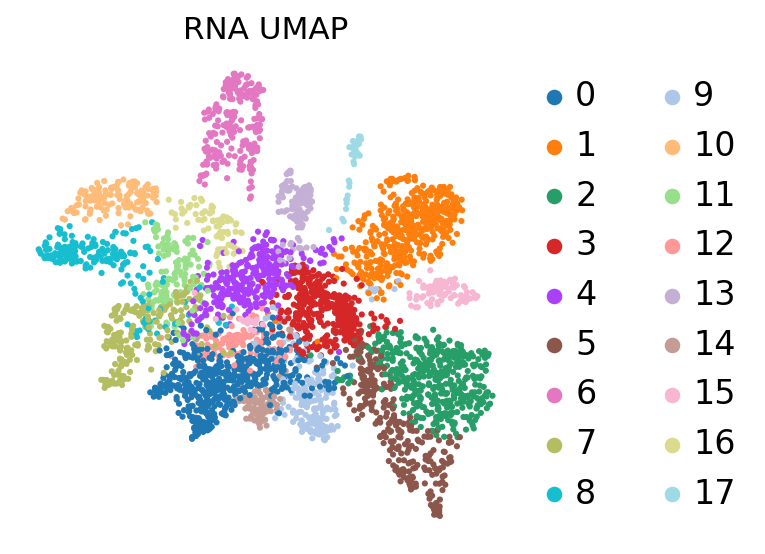

In [9]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

# Load marker gene database

Use cell type specific marker genes to annotate single cell clusters. Marker genes that are mainly expressed exclusively by a specific cell type, making them useful to distinguish heterogeneous groups of cells. Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.

## PanglaoDB

In [10]:
# Show all available databases
dc.show_resources()

['Adhesome',
 'Almen2009',
 'Baccin2019',
 'CORUM_Funcat',
 'CORUM_GO',
 'CSPA',
 'CSPA_celltype',
 'CancerDrugsDB',
 'CancerGeneCensus',
 'CancerSEA',
 'CellCall',
 'CellCellInteractions',
 'CellChatDB',
 'CellChatDB_complex',
 'CellPhoneDB',
 'CellPhoneDB_complex',
 'CellTalkDB',
 'CellTypist',
 'Cellinker',
 'Cellinker_complex',
 'ComPPI',
 'CytoSig',
 'DGIdb',
 'DisGeNet',
 'EMBRACE',
 'Exocarta',
 'GO_Intercell',
 'GPCRdb',
 'Guide2Pharma',
 'HGNC',
 'HPA_secretome',
 'HPA_subcellular',
 'HPA_tissue',
 'HPMR',
 'HumanCellMap',
 'ICELLNET',
 'ICELLNET_complex',
 'IntOGen',
 'Integrins',
 'InterPro',
 'KEGG-PC',
 'Kirouac2010',
 'LOCATE',
 'LRdb',
 'Lambert2018',
 'MCAM',
 'MSigDB',
 'Matrisome',
 'MatrixDB',
 'Membranome',
 'NetPath',
 'OPM',
 'PROGENy',
 'PanglaoDB',
 'Phobius',
 'Phosphatome',
 'Ramilowski2015',
 'Ramilowski_location',
 'SIGNOR',
 'SignaLink_function',
 'SignaLink_pathway',
 'Surfaceome',
 'TCDB',
 'TFcensus',
 'TopDB',
 'UniProt_family',
 'UniProt_keyword',
 'Un

In [11]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [12]:
markers["organ"].value_counts()

organ
Immune system         1760
Brain                 1589
GI tract               539
Kidney                 450
Reproductive           428
Connective tissue      413
Vasculature            373
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        167
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                29
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: count, dtype: int64

In [13]:
# # Human and mouse
# brain_markers = markers[(markers['organ']=='Immune system') | (markers['human_sensitivity']=='Brain') & markers['canonical_marker']]

# # Human only
# brain_markers = markers[(markers['organ']=='Immune system') | (markers['human_sensitivity']=='Brain') & markers['canonical_marker'] & markers['human']]

# Human only with high sensitivity
brain_markers = markers[(markers['organ']=='Immune system') | (markers['human_sensitivity']=='Brain') & markers['canonical_marker'] & markers['human'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
brain_markers = brain_markers[~brain_markers.duplicated(['cell_type', 'genesymbol'])]

brain_markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.000000,0.008202,True,1.000000,0.012914,9606,Immune system,0.013
32,CPA1,False,Mast cells,Mesoderm,True,0.000000,0.003141,True,0.000000,0.007011,9606,Immune system,0.006
58,GDF15,True,Macrophages,Mesoderm,True,0.166667,0.056604,True,0.018182,0.002584,9606,Immune system,0.014
106,LYZ,True,Neutrophils,Mesoderm,True,0.615385,0.038377,False,0.000000,0.000000,9606,Immune system,0.008
109,LYZ,True,Dendritic cells,Mesoderm,True,0.442177,0.021347,False,0.000000,0.000000,9606,Immune system,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8336,ARHGAP45,False,T memory cells,Mesoderm,True,0.317073,0.010473,True,0.884375,0.085621,9606,Immune system,0.088
8337,CTLA4,True,T regulatory cells,Mesoderm,True,0.000000,0.008145,True,1.000000,0.002759,9606,Immune system,0.004
8338,IZUMO1R,False,T regulatory cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.002503,9606,Immune system,0.002
8339,TNFRSF18,False,T regulatory cells,Mesoderm,True,0.000000,0.013784,True,0.000000,0.000000,9606,Immune system,0.013


In [14]:
brain_markers['human'].value_counts()

human
True     1531
False     213
Name: count, dtype: int64

## Cellmarker

In [15]:
ls CellMarker_DB

Cell_marker_All.csv   Cell_marker_Human.csv   Cell_marker_Mouse.csv   Cell_marker_Seq.csv
Cell_marker_All.xlsx  Cell_marker_Human.xlsx  Cell_marker_Mouse.xlsx  Cell_marker_Seq.xlsx


In [16]:
markers = pd.read_csv('CellMarker_DB/Cell_marker_Seq.csv')
markers = markers[(markers['species']=='Human') & (markers['tissue_type']=='Brain')]
markers = markers.rename(columns={'Symbol': 'genesymbol'})
markers

,species,tissue_class,tissue_type,uberonongology_id,cancer_type,cell_type,cell_name,cellontology_id,marker,genesymbol,GeneID,Genetype,Genename,UNIPROTID,technology_seq,marker_source,PMID,Title,journal,year
5362,Human,Brain,Brain,UBERON_0000955,Normal,Normal cell,Microglial cell,CL_0000129,CD11b,NaN,NaN,NaN,NaN,NaN,CyTOF,Experiment,30559476.0,Human microglia regional heterogeneity and phe...,Nature neuroscience,2019.0
5363,Human,Brain,Brain,UBERON_0000955,Normal,Normal cell,Microglial cell,CL_0000129,P2Y12,P2RY12,64805.0,protein_coding,purinergic receptor P2Y12,A8K7T1,CyTOF,Experiment,30559476.0,Human microglia regional heterogeneity and phe...,Nature neuroscience,2019.0
5364,Human,Brain,Brain,UBERON_0000955,Normal,Normal cell,Microglial cell,CL_0000129,CD45,PTPRC,5788.0,protein_coding,protein tyrosine phosphatase receptor type C,M9MML4,CyTOF,Experiment,30559476.0,Human microglia regional heterogeneity and phe...,Nature neuroscience,2019.0
5365,Human,Brain,Brain,UBERON_0000955,Normal,Normal cell,Microglial cell,CL_0000129,TMEM119,TMEM119,338773.0,protein_coding,transmembrane protein 119,Q4V9L6,CyTOF,Experiment,30559476.0,Human microglia regional heterogeneity and phe...,Nature neuroscience,2019.0
5366,Human,Brain,Brain,UBERON_0000955,Normal,Normal cell,Stem cell,CL_0000034,BLBP,FABP7,2173.0,protein_coding,fatty acid binding protein 7,O15540,Smart-seq2,Experiment,30581079.0,Identification of Embryonic Neural Plate Borde...,Cell stem cell,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Human,Brain,Brain,UBERON_0000955,Glioblastoma,Cancer cell,Effector memory T cell,CL_0000813,SELL,SELL,6402.0,protein_coding,selectin L,P14151,10x Chromium,Experiment,35464424.0,Characterising Distinct Migratory Profiles of ...,Frontiers in immunology,2022.0
9995,Human,Brain,Brain,UBERON_0000955,Glioblastoma,Cancer cell,Effector memory T cell,CL_0000813,IL7R,IL7R,3575.0,protein_coding,interleukin 7 receptor,P16871,10x Chromium,Experiment,35464424.0,Characterising Distinct Migratory Profiles of ...,Frontiers in immunology,2022.0
9996,Human,Brain,Brain,UBERON_0000955,Glioblastoma,Cancer cell,Effector memory T cell,CL_0000813,KLRG1,KLRG1,10219.0,protein_coding,killer cell lectin like receptor G1,Q96E93,10x Chromium,Experiment,35464424.0,Characterising Distinct Migratory Profiles of ...,Frontiers in immunology,2022.0
9997,Human,Brain,Brain,UBERON_0000955,Glioblastoma,Cancer cell,Effector memory T cell,CL_0000813,PTGER2,PTGER2,5732.0,protein_coding,prostaglandin E receptor 2,P43116,10x Chromium,Experiment,35464424.0,Characterising Distinct Migratory Profiles of ...,Frontiers in immunology,2022.0


# Automatic annotation

## Enrichment with Over Representation Analysis

ORA (Over representation analysis): the top 5% of expressed genes by sample are selected as the set of interest (S)

In [17]:
dc.run_ora(
    mat=adata,
    net=brain_markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 3869 samples and 7551 targets for 23 sources.


100%|██████████| 3869/3869 [00:01<00:00, 2049.55it/s]


In [18]:
adata.obsm['ora_estimate']

source,B cells,B cells memory,B cells naive,Basophils,Dendritic cells,Eosinophils,Gamma delta T cells,Macrophages,Mast cells,Megakaryocytes,...,Natural killer T cells,Neutrophils,Plasma cells,Plasmacytoid dendritic cells,Red pulp macrophages,T cells,T follicular helper cells,T helper cells,T memory cells,T regulatory cells
SUDIPG65Nuc-P1-A01,0.434644,0.688885,0.760087,0.481113,1.324118,0.965821,1.615896,1.324118,-0.000000,-0.000000,...,-0.000000,0.536421,-0.000000,-0.000000,-0.00000,1.266732,1.133778,0.760087,0.603847,0.965821
SUDIPG65Nuc-P1-A02,1.125806,0.688885,0.760087,0.481113,2.061913,0.965821,0.658093,1.324118,0.287317,-0.000000,...,-0.000000,-0.000000,-0.000000,0.603847,-0.00000,0.498435,-0.000000,-0.000000,0.603847,0.965821
SUDIPG65Nuc-P1-A03,1.125806,-0.000000,1.838577,0.481113,0.709880,-0.000000,0.658093,-0.000000,0.792921,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.498435,-0.000000,0.760087,-0.000000,-0.000000
SUDIPG65Nuc-P1-A04,-0.000000,-0.000000,0.760087,0.481113,0.709880,0.965821,-0.000000,-0.000000,1.459684,0.760087,...,0.801835,-0.000000,-0.000000,-0.000000,-0.00000,0.498435,1.133778,-0.000000,0.603847,0.965821
SUDIPG65Nuc-P1-A05,-0.000000,-0.000000,-0.000000,-0.000000,0.251686,-0.000000,-0.000000,-0.000000,0.287317,-0.000000,...,-0.000000,0.536421,0.629866,0.603847,-0.00000,-0.000000,1.133778,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MUV_001-P14-G01,1.995764,-0.000000,-0.000000,0.481113,-0.000000,-0.000000,2.778897,-0.000000,0.287317,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.498435,-0.000000,-0.000000,-0.000000,2.293975
MUV_001-P14-G02,1.125806,0.688885,1.838577,1.228587,2.061913,-0.000000,0.658093,3.830032,0.287317,-0.000000,...,-0.000000,-0.000000,-0.000000,2.589434,1.25463,0.498435,-0.000000,0.760087,-0.000000,-0.000000
MUV_001-P14-G12,-0.000000,-0.000000,-0.000000,-0.000000,1.324118,-0.000000,4.105417,0.251686,1.459684,0.760087,...,3.286549,-0.000000,-0.000000,0.603847,-0.00000,0.498435,-0.000000,-0.000000,0.603847,0.965821
MUV_001-P14-H01,1.125806,-0.000000,-0.000000,-0.000000,2.061913,-0.000000,1.615896,-0.000000,1.459684,0.760087,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,-0.000000,-0.000000,-0.000000,0.965821


In [19]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e
acts

AnnData object with n_obs × n_vars = 3869 × 23
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

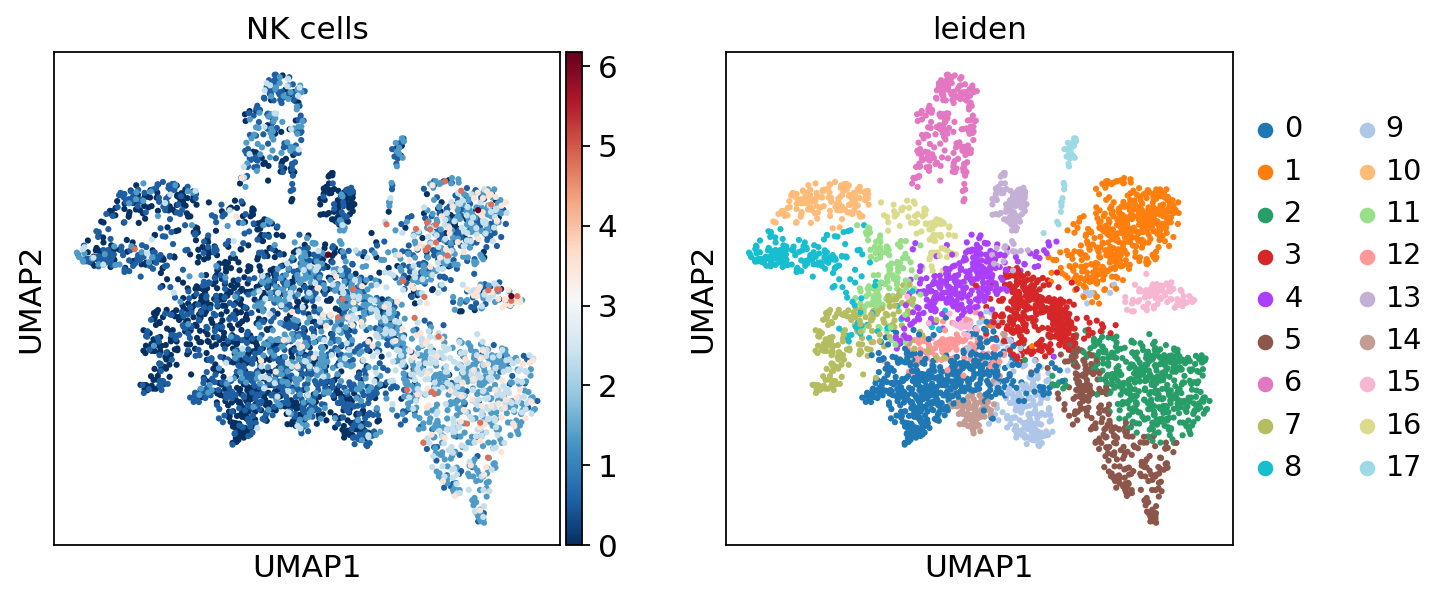

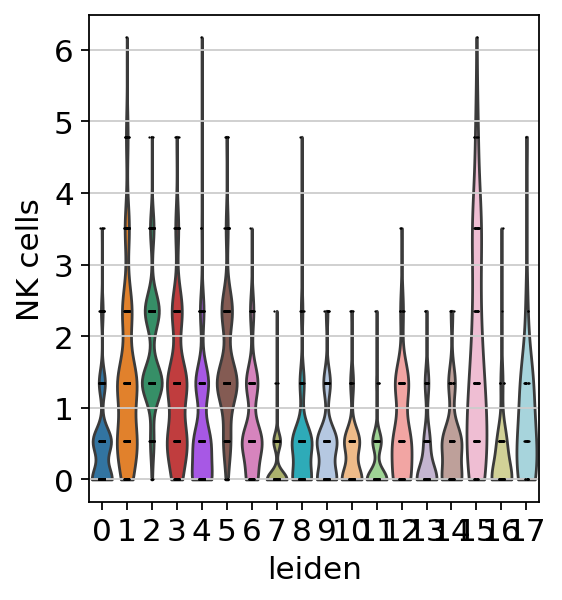

In [20]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

In [21]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Megakaryocytes,6.253577,0.232634,5.839893e-10,8.954503e-10
1,0,rest,Natural killer T cells,5.119211,0.212737,3.652606e-07,4.667219e-07
2,0,rest,T follicular helper cells,2.952131,0.132585,3.226364e-03,3.710319e-03
3,0,rest,Mast cells,2.120639,0.117528,3.418665e-02,3.744252e-02
4,0,rest,T regulatory cells,0.670933,0.028554,5.024102e-01,5.024102e-01
...,...,...,...,...,...,...,...
409,9,rest,B cells memory,-5.709556,-0.282699,2.922979e-08,1.120475e-07
410,9,rest,T memory cells,-5.878107,-0.349897,1.183422e-08,5.443740e-08
411,9,rest,Eosinophils,-6.680842,-0.427615,1.087191e-10,6.251348e-10
412,9,rest,Dendritic cells,-6.860135,-1.349581,5.415684e-11,4.152025e-10


In [22]:
df['names'].value_counts()

names
Megakaryocytes                      18
T memory cells                      18
Eosinophils                         18
Dendritic cells                     18
T helper cells                      18
Plasmacytoid dendritic cells        18
B cells                             18
NK cells                            18
B cells memory                      18
Neutrophils                         18
Gamma delta T cells                 18
T cells                             18
Natural killer T cells              18
Monocytes                           18
B cells naive                       18
Red pulp macrophages                18
Plasma cells                        18
Myeloid-derived suppressor cells    18
Basophils                           18
T regulatory cells                  18
Mast cells                          18
T follicular helper cells           18
Macrophages                         18
Name: count, dtype: int64

In [23]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Megakaryocytes',
  'Natural killer T cells',
  'T follicular helper cells'],
 '1': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 '10': ['Plasmacytoid dendritic cells', 'B cells naive', 'Eosinophils'],
 '11': ['Gamma delta T cells', 'Plasmacytoid dendritic cells', 'Plasma cells'],
 '12': ['Megakaryocytes',
  'Natural killer T cells',
  'T follicular helper cells'],
 '13': ['Gamma delta T cells', 'Megakaryocytes', 'B cells'],
 '14': ['Megakaryocytes', 'Natural killer T cells', 'T regulatory cells'],
 '15': ['T memory cells', 'Plasma cells', 'T cells'],
 '16': ['Plasmacytoid dendritic cells', 'B cells naive', 'B cells memory'],
 '17': ['Neutrophils', 'Monocytes', 'Dendritic cells'],
 '2': ['NK cells', 'T helper cells', 'T regulatory cells'],
 '3': ['T helper cells', 'Basophils', 'Eosinophils'],
 '4': ['Basophils', 'Plasmacytoid dendritic cells', 'Plasma cells'],
 '5': ['T helper cells', 'Eosinophils', 'NK cells'],
 '6': ['Mast cells',
  'Plasmacytoid dendritic cells',
  'Myelo

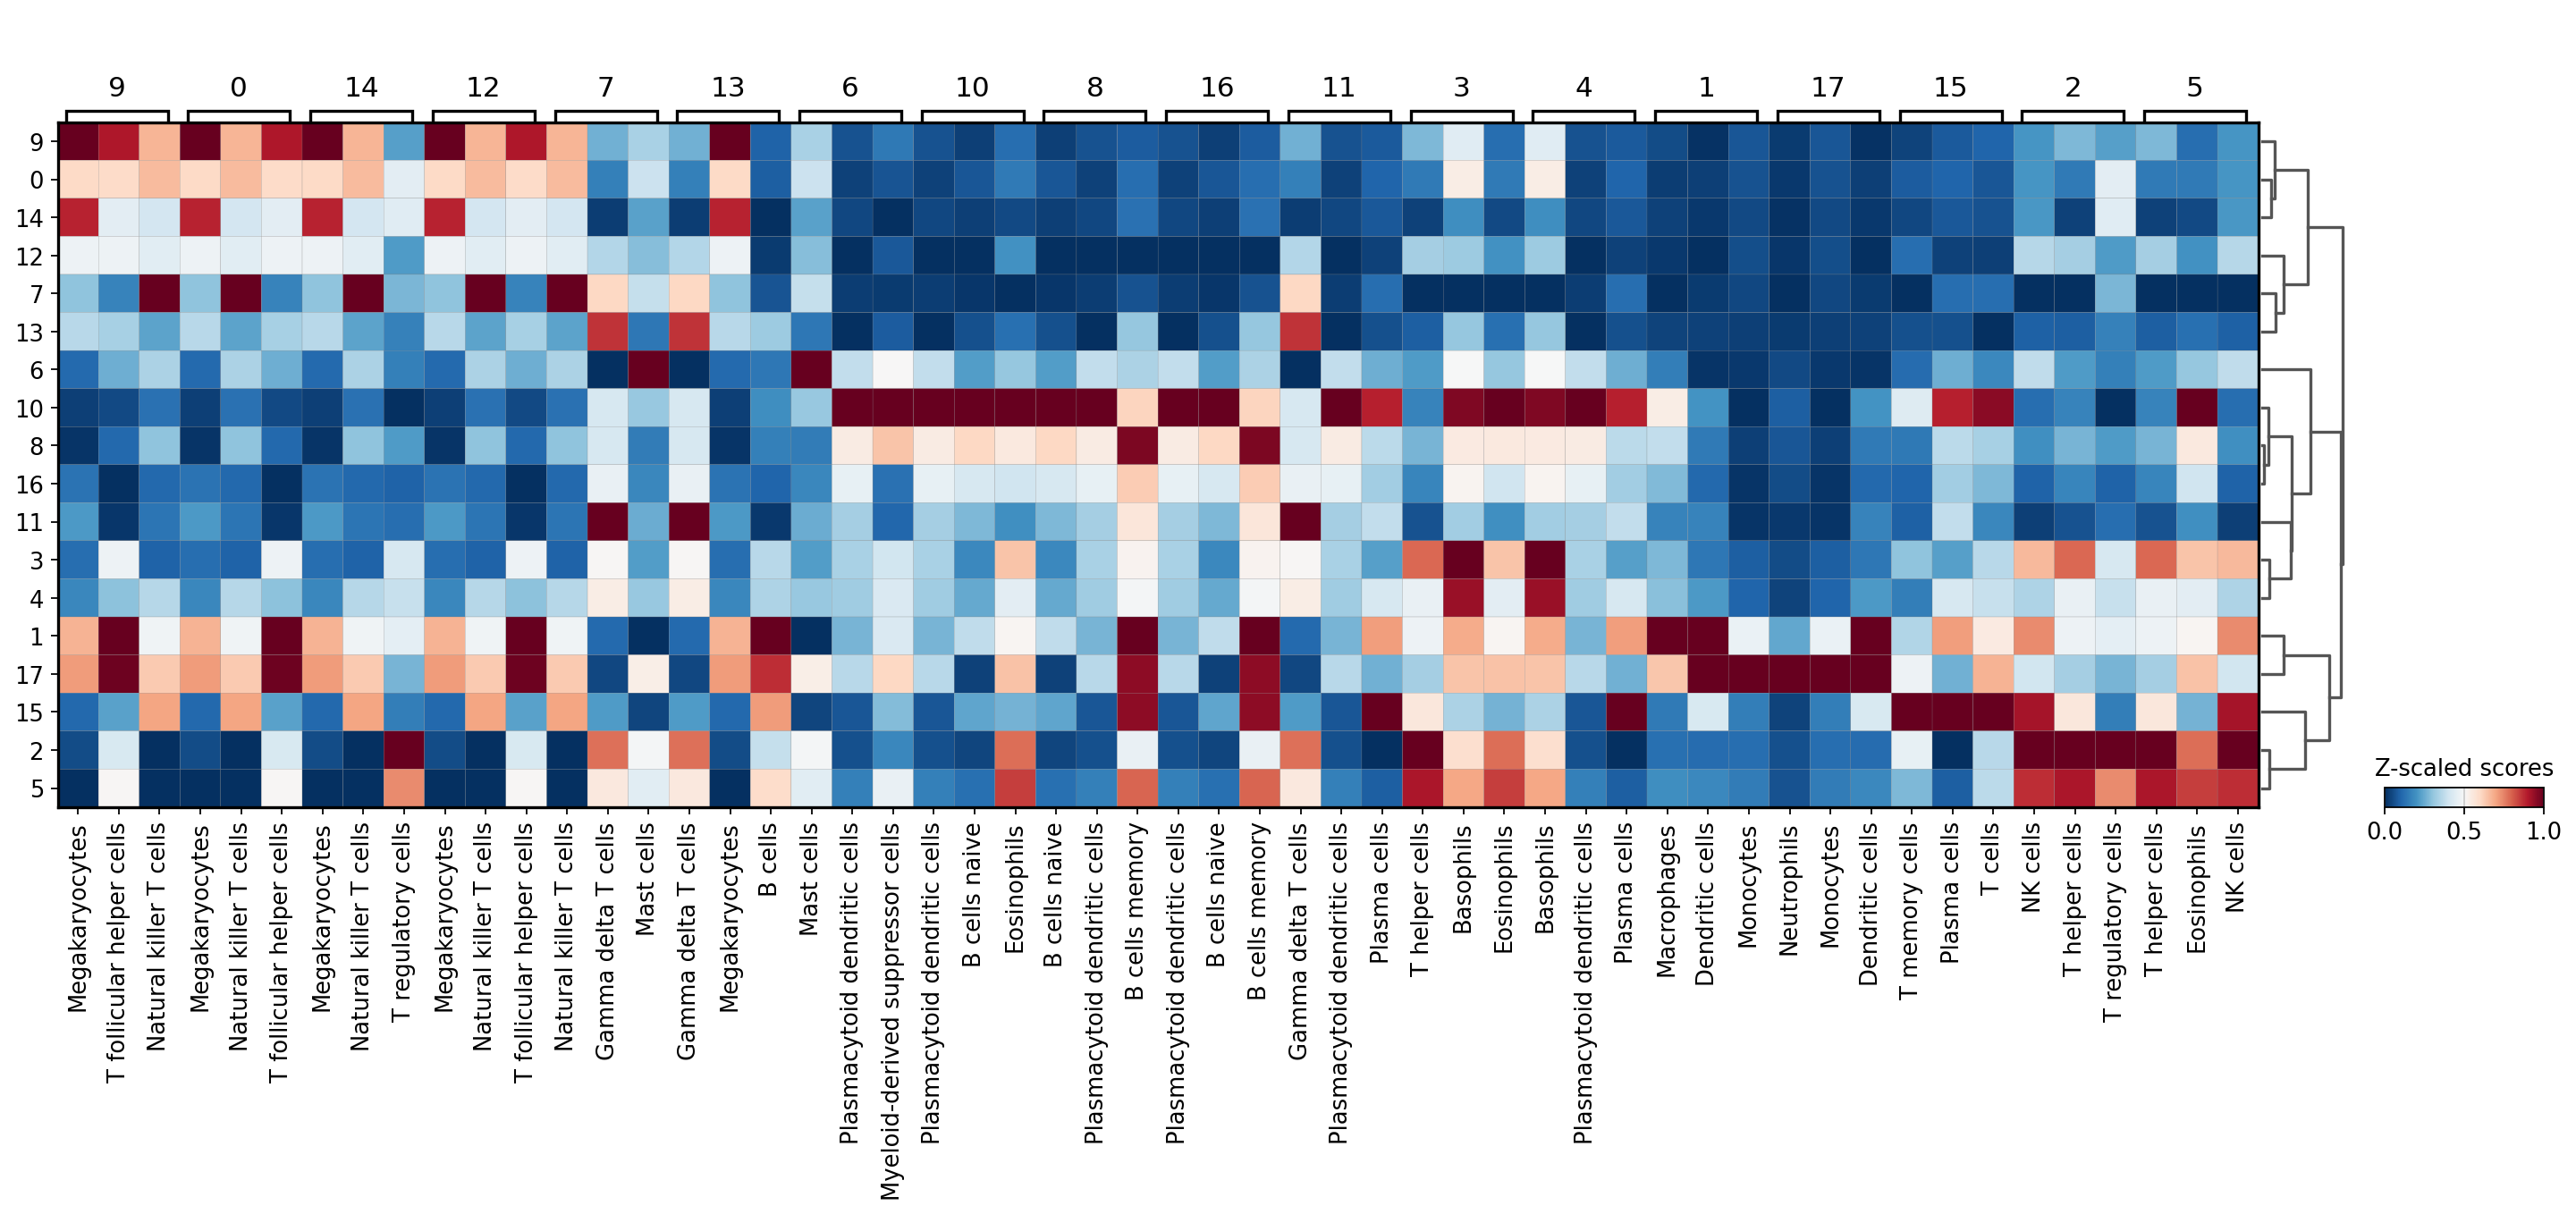

In [24]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [25]:
# sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

In [26]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Megakaryocytes',
 '1': 'Macrophages',
 '10': 'Plasmacytoid dendritic cells',
 '11': 'Gamma delta T cells',
 '12': 'Megakaryocytes',
 '13': 'Gamma delta T cells',
 '14': 'Megakaryocytes',
 '15': 'T memory cells',
 '16': 'Plasmacytoid dendritic cells',
 '17': 'Neutrophils',
 '2': 'NK cells',
 '3': 'T helper cells',
 '4': 'Basophils',
 '5': 'T helper cells',
 '6': 'Mast cells',
 '7': 'Natural killer T cells',
 '8': 'B cells naive',
 '9': 'Megakaryocytes'}

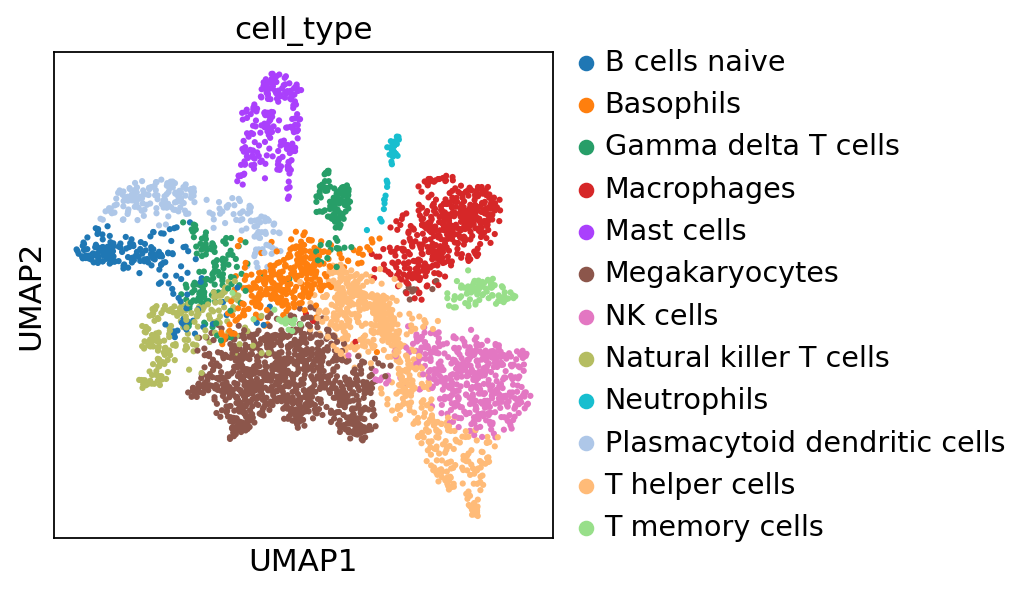

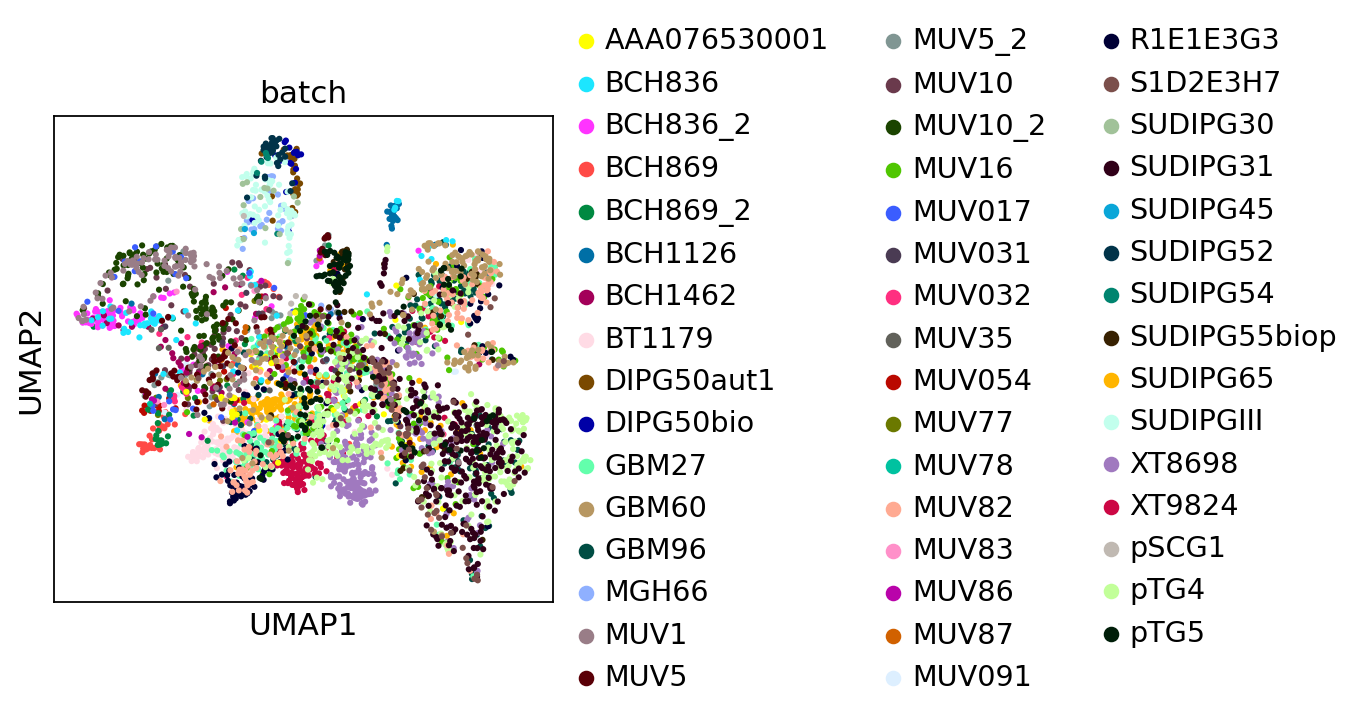

In [27]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color=['cell_type'])
sc.pl.umap(adata, color=['batch'])



In [28]:
# adata.write_h5ad("./human_mouse_scrna.h5ad")
# adata.write_h5ad("./human_only_scrna.h5ad")
# adata.write_h5ad("./human_sensitive_scrna.h5ad")
adata.write_h5ad("./Cellmarkers_scrna.h5ad")



In [29]:
ls

CellMarker_DB/                GSE184357_scATAC_counts.tar  human_sensitive_scrna.h5ad
Cellmarkers_scrna.h5ad        human_mouse_scrna.h5ad       scATAC_counts/
GSE184357_DMG_raw_counts.tar  human_only_scrna.h5ad        scRNA_counts/
